In [1]:
import pandas as pd
import numpy as np
import os,sys
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt

In [2]:
fdir = os.path.join(sys.path[0],"data/")
flist = os.listdir(fdir)
DataSet = {}
for file in flist:
    # print(file)
    Coinname = file.replace("coin_", "", 1).replace(".csv","",1)
    # print(Coinname)
    DataSet[Coinname] = pd.read_csv("data/"+file)

In [3]:
for key in DataSet:
    print(key)

Aave
BinanceCoin
Bitcoin
Cardano
ChainLink
Cosmos
CryptocomCoin
Dogecoin
EOS
Ethereum
Iota
Litecoin
Monero
NEM
Polkadot
Solana
Stellar
Tether
Tron
Uniswap
USDCoin
WrappedBitcoin
XRP


In [4]:
coin = "Bitcoin"
# DataSet["Bitcoin"].drop(columns=["SNo","Name","Symbol"])
df = DataSet[coin][['Date','Close']].set_index("Date")
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000


<AxesSubplot:xlabel='Date'>

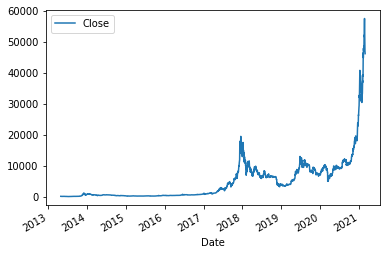

In [5]:
df.plot()

In [6]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [7]:
ts = df
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                    4.617884
p-value                           1.000000
#lags Used                       28.000000
Number of Observations Used    2833.000000
Critical Value (1%)              -3.432660
Critical Value (5%)              -2.862561
Critical Value (10%)             -2.567313
dtype: float64


In [8]:
ts.index

DatetimeIndex(['2013-04-29 23:59:59', '2013-04-30 23:59:59',
               '2013-05-01 23:59:59', '2013-05-02 23:59:59',
               '2013-05-03 23:59:59', '2013-05-04 23:59:59',
               '2013-05-05 23:59:59', '2013-05-06 23:59:59',
               '2013-05-07 23:59:59', '2013-05-08 23:59:59',
               ...
               '2021-02-18 23:59:59', '2021-02-19 23:59:59',
               '2021-02-20 23:59:59', '2021-02-21 23:59:59',
               '2021-02-22 23:59:59', '2021-02-23 23:59:59',
               '2021-02-24 23:59:59', '2021-02-25 23:59:59',
               '2021-02-26 23:59:59', '2021-02-27 23:59:59'],
              dtype='datetime64[ns]', name='Date', length=2862, freq=None)

In [9]:
# print(type(ts.index))
# xticks = pd.to_datetime(pd.Series(ts.index[::100])).dt.date.toString()
# print(pd.to_datetime(pd.Series(ts.index[::100])).strftime("%m/%d/%Y"))
xticks = pd.to_datetime(ts.index[::100],format='%Y-%m-%d')

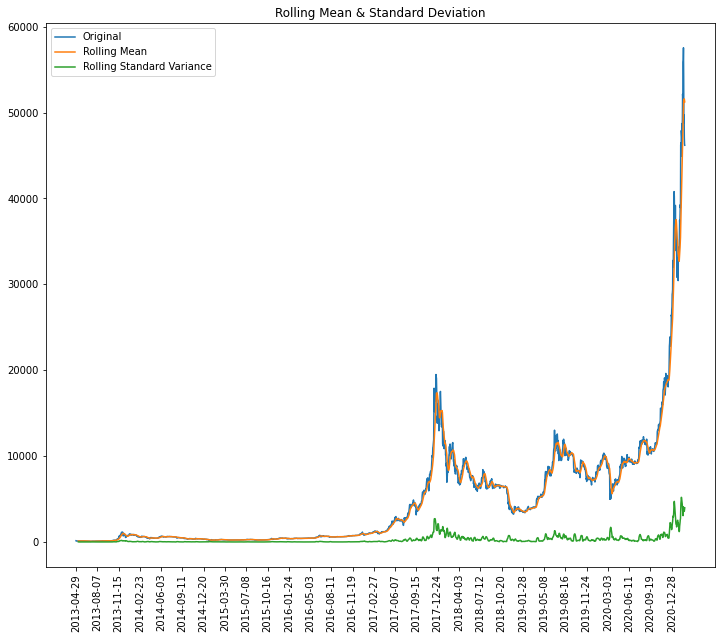

In [22]:
# Rolling Statistics
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()
plt.figure(figsize=(12,10))
plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xticks(ts.index[::100], rotation='vertical')
plt.show(block=False)

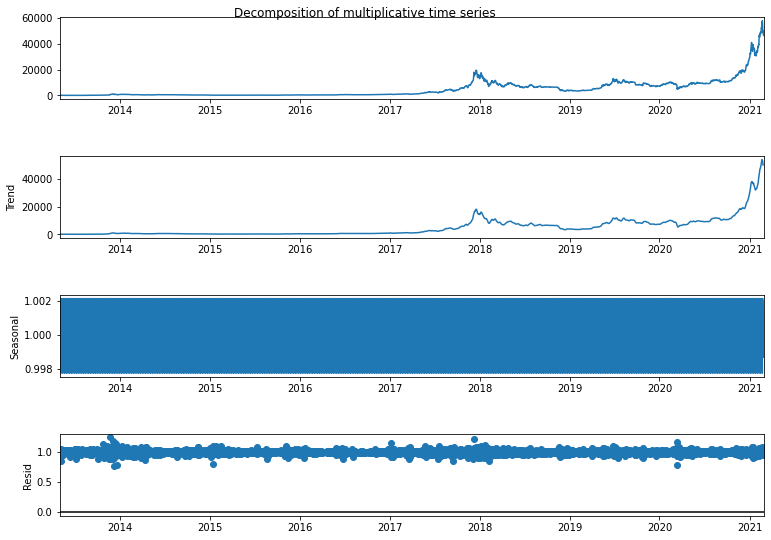

In [11]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [12]:
# Lets Resample the data by Month and analyze again
ts_m = ts.resample('M').mean()
print (type(ts_m))
print (ts_m.head(3))
tsm = ts_m['Close']
print(type(tsm))
test_stationarity(tsm)

<class 'pandas.core.frame.DataFrame'>
                 Close
Date                  
2013-04-30  141.769997
2013-05-31  119.992741
2013-06-30  107.761407


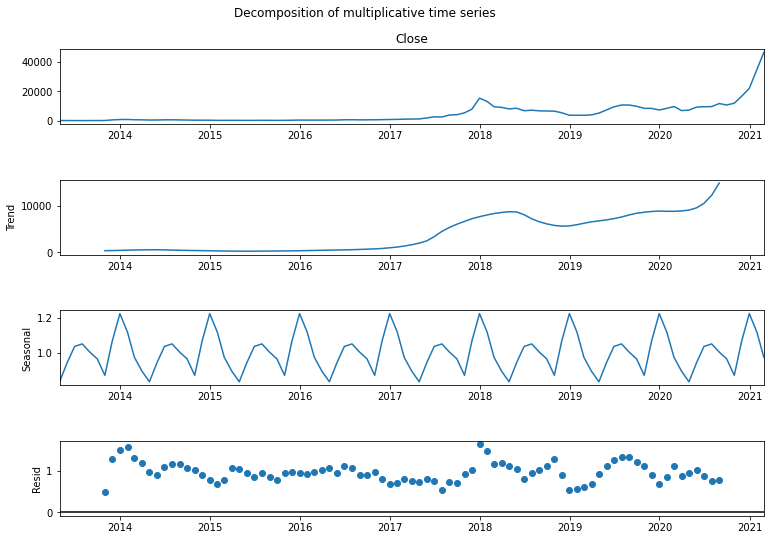

In [15]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [16]:
# lets try to make the "tsm" Stationary

tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
# Stationarity Check
test_stationarity(tsmlogdiff)

Results of Dickey-Fuller Test:
Test Statistic                -6.482525e+00
p-value                        1.284476e-08
#lags Used                     0.000000e+00
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64


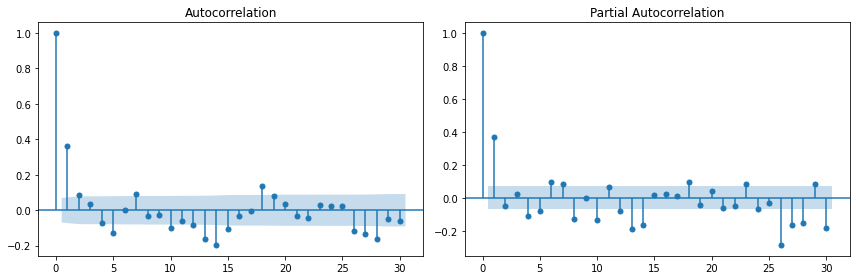

In [17]:
# Let's plot ACF & PACF graphs to visualize AR & MA components

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [18]:
# contrived dataset
data = ts["Close"]
# fit model
model = ARIMA(data, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

C:\Users\cools\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\cools\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\cools\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\cools\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
2021-02-28 23:59:59    27102.177425
Freq: D, dtype: float64


In [21]:
# contrived dataset
# data1 = [x + random() for x in range(1, 100)]
# data2 = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(dfMonth['Close_box'], exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])
print(yhat)

NameError: name 'data2' is not defined